In [48]:
import matplotlib
import operator
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 10

# import custom functions
from functions_statistical_performance import *

In [50]:
df0=pd.read_csv('./output_data/FNDDS_2009-10_99_Nutrients_ensemble_5folds.csv')
df1=pd.read_csv('./output_data/FNDDS_2009-10_62Nutrients_ensemble_5folds.csv')
df2=pd.read_csv('./output_data/FNDDS_2015-16_62Nutrients_ensemble_5folds.csv')
dfprecision=pd.read_csv('./input_data/FNDDS_nutrients_precision.csv')

In [51]:
df0.drop(columns=['Unnamed: 0'], inplace=True)
df1.drop(columns=['Unnamed: 0'], inplace=True)
df2.drop(columns=['Unnamed: 0'], inplace=True)
df2.rename(columns={"Food code": "Food_code", "Main food description": "Main_food_description"}, inplace=True)

In [52]:
# nutrient list considered in the analysis
nutlist=[ 'Protein',
 'Total Fat',
 'Carbohydrate',
 'Alcohol',
 'Water',
 'Caffeine',
 'Theobromine',
 'Sugars, total',
 'Fiber, total dietary',
 'Calcium',
 'Iron',
 'Magnesium',
 'Phosphorus',
 'Potassium',
 'Sodium',
 'Zinc',
 'Copper',
 'Selenium',
 'Retinol',
 'Carotene, beta',
 'Carotene, alpha',
 'Vitamin E (alpha-tocopherol)',
 'Vitamin D (D2 + D3)',
 'Cryptoxanthin, beta',
 'Lycopene',
 'Lutein + zeaxanthin',
 'Vitamin C',
 'Thiamin',
 'Riboflavin',
 'Niacin',
 'Vitamin B-6',
 'Folate, total',
 'Vitamin B-12',
 'Choline, total',
 'Vitamin K (phylloquinone)',
 'Folic acid',
 'Folate, food',
 'Vitamin E, added',
 'Vitamin B-12, added',
 'Cholesterol',
 'Fatty acids, total saturated',
 '4:00',
 '6:00',
 '8:00',
 '10:00',
 '12:00',
 '14:00',
 '16:00',
 '18:00',
 '18:01',
 '18:02',
 '18:03',
 '20:04',
 '22:6 n-3',
 '16:01',
 '18:04',
 '20:01',
 '20:5 n-3',
 '22:01',
 '22:5 n-3',
 'Fatty acids, total monounsaturated',
 'Fatty acids, total polyunsaturated']

In [53]:
# concat to propagate information and merge to compare 2009-2010 vs 2015-2016 with 62 nutrients
df01=pd.concat([df0[[ "Food_code","Main_food_description"]], df1[nutlist+['FPro','std_FPro','p1','p2','p3','p4','class']]], axis=1)
df2=df2[[ "Food_code","Main_food_description"]+nutlist+['FPro','std_FPro','p1','p2','p3','p4','class']]
db2compare=pd.merge(df01,df2,on="Food_code")


In [54]:
# dictionary nutrient to minimal difference
mindiff={x:y for (x,y) in dfprecision[['Nutrient description', 'MinDiff']].values}

In [55]:
db2compare['avg_abs_log_nut_change']=np.mean(abs(db2compare[[n+'_x'for n in nutlist]].values-db2compare[[n+'_y'for n in nutlist]].values), axis=1)
db2compare['max_abs_log_nut_change']=np.amax(abs(db2compare[[n+'_x'for n in nutlist]].values-db2compare[[n+'_y'for n in nutlist]].values), axis=1)

db2compare['avg_abs_nut_change']=np.exp(np.mean(abs(db2compare[[n+'_x'for n in nutlist]].values-db2compare[[n+'_y'for n in nutlist]].values), axis=1))
db2compare['max_abs_nut_change']=np.exp(np.amax(abs(db2compare[[n+'_x'for n in nutlist]].values-db2compare[[n+'_y'for n in nutlist]].values), axis=1))

# where max change
db2compare['nutrient_max_change']=[nutlist[i] for i in np.argmax(abs(db2compare[[n+'_x'for n in nutlist]].values-db2compare[[n+'_y'for n in nutlist]].values), axis=1)]

# how many nutrients changed
db2compare['num_nut_change']=np.sum(abs(db2compare[[n+'_x'for n in nutlist]].values-db2compare[[n+'_y'for n in nutlist]].values)>0, axis=1)
dbdiff=pd.DataFrame.from_dict({n:np.around(abs(np.exp(db2compare[n+'_x'])-np.exp(db2compare[n+'_y'])), decimals=int(abs(np.log10(mindiff[n]))))>=mindiff[n] for n in nutlist})
db2compare['num_nut_change_real']=dbdiff.sum(axis=1)
db2compare['abs_diff_FPro']=abs(db2compare['FPro_x']-db2compare['FPro_y'])


In [56]:
db2compare

,Food_code,Main_food_description_x,Protein_x,Total Fat_x,Carbohydrate_x,Alcohol_x,Water_x,Caffeine_x,Theobromine_x,"Sugars, total_x",...,p4_y,class_y,avg_abs_log_nut_change,max_abs_log_nut_change,avg_abs_nut_change,max_abs_nut_change,nutrient_max_change,num_nut_change,num_nut_change_real,abs_diff_FPro
0,11000000,"Milk, human",0.029559,1.477049,1.930071,-20.0,4.471639,-20.0,-20.0,1.930071,...,0.098795,0,0.000000,0.000000,1.000000,1.000000e+00,Protein,0,0,0.000000
1,11100000,"Milk, NFS",1.187843,0.647103,1.578979,-20.0,4.491441,-20.0,-20.0,1.625311,...,0.009344,0,0.020491,0.133531,1.020703,1.142857e+00,Cholesterol,24,24,0.007933
2,11111000,"Milk, cow's, fluid, whole",1.147402,1.178655,1.568616,-20.0,4.478813,-20.0,-20.0,1.619388,...,0.001056,0,0.000000,0.000000,1.000000,1.000000e+00,Protein,0,0,0.000000
3,11111100,"Milk, cow's, fluid, whole, low-sodium",1.131402,1.241269,1.495149,-20.0,4.479607,-20.0,-20.0,1.495149,...,0.064870,0,0.000000,0.000000,1.000000,1.000000e+00,Protein,0,0,0.000000
4,11111150,"Milk, calcium fortified, cow's, fluid, whole",1.144223,1.175573,1.566530,-20.0,4.475858,-20.0,-20.0,1.617406,...,0.001056,0,0.021527,1.293636,1.021760,3.646018e+00,Calcium,14,14,0.000111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5627,94100200,"Water, bottled, sweetened, with low or no calo...",-20.000000,-20.000000,-1.897120,-20.0,4.603669,-20.0,-20.0,-20.000000,...,0.807161,3,0.027154,1.540445,1.027526,4.666667e+00,Sodium,2,2,0.068385
5628,94100300,"Water, fruit flavored, sweetened, with high fr...",-20.000000,-20.000000,1.504077,-20.0,4.547965,-20.0,-20.0,1.504077,...,0.936296,3,0.000000,0.000000,1.000000,1.000000e+00,Protein,0,0,0.000000
5629,94210100,Propel Water,-20.000000,-20.000000,0.198851,-20.0,4.592895,-20.0,-20.0,0.198851,...,0.935333,3,0.341907,20.198851,1.407629,5.919015e+08,"Sugars, total",3,3,0.014944
5630,94210200,Glaceau Water,-20.000000,-20.000000,1.702928,-20.0,4.547965,-20.0,-20.0,1.702928,...,0.905556,3,0.000000,0.000000,1.000000,1.000000e+00,Protein,0,0,0.000000


# Statistics in the paper

Number of data points
451
Median Delta FPro
0.0015555555555554212
Mean Delta FPro
0.006255401461203384
std Delta FPro
0.023114142080193814
Quantiles
0.25    0.000222
0.50    0.001556
0.75    0.004778
Name: abs_diff_FPro, dtype: float64
%%%%%%%%%%%%%%%%%%%%%
Number of data points
1131
Median Delta FPro
0.0032989417989417458
Mean Delta FPro
0.015729089531049446
std Delta FPro
0.04724370588568179
Quantiles
0.25    0.000715
0.50    0.003299
0.75    0.011287
Name: abs_diff_FPro, dtype: float64


/Users/giulia/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/giulia/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


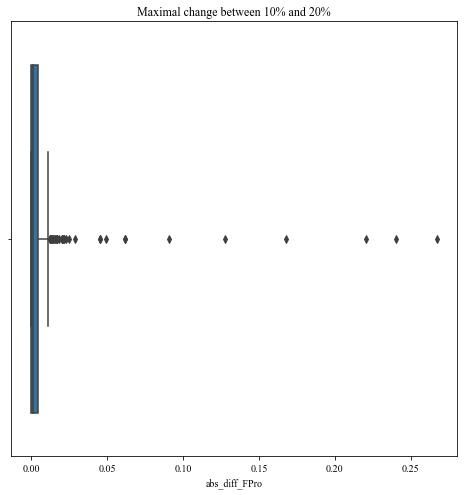

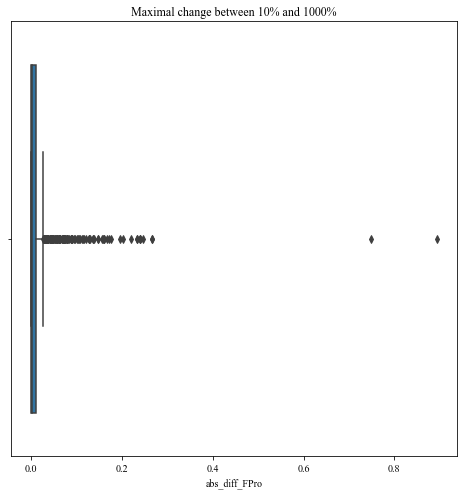

In [57]:
# Maximal change between 10% and 20%
ll=1.1
up=1.5
print("Number of data points")
print(sum((db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)))

print("Median Delta FPro")
print(np.median(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)]))

print("Mean Delta FPro")
print(np.mean(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)]))

print("std Delta FPro")
print(np.std(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)]))

print("Quantiles")
print(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)].quantile([0.25,0.5,0.75]))


plt.figure(figsize = (8, 8))
sns.boxplot(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)])
plt.title("Maximal change between 10% and 20%");
print('%%%%%%%%%%%%%%%%%%%%%')

# Maximal change between 10% and 1000%
ll=1.1
up=11
print("Number of data points")
print(sum((db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)))

print("Median Delta FPro")
print(np.median(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)]))

print("Mean Delta FPro")
print(np.mean(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)]))

print("std Delta FPro")
print(np.std(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)]))

print("Quantiles")
print(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)].quantile([0.25,0.5,0.75]))

plt.figure(figsize = (8, 8))
sns.boxplot(db2compare["abs_diff_FPro"][(db2compare["max_abs_nut_change"]>=ll)&(db2compare["max_abs_nut_change"]<=up)])
plt.title("Maximal change between 10% and 1000%");

# Examples for Paper
11111150 Milk, calcium fortified, cow's, fluid, whole (14 nutrients changed)

53247500 Cookie, vanilla with caramel, coconut, and chocolate coating (46 nutrients changes)

In [58]:
# Milk, calcium fortified, cow's, fluid, whole 
db2compare.loc[db2compare['Food_code']==11111150, 'num_nut_change_real']

4    14
Name: num_nut_change_real, dtype: int64

In [59]:
idF=db2compare.loc[db2compare['Food_code']==11111150, 'num_nut_change_real'].index[0]
db2compare.loc[idF,[db2compare.loc[idF,'nutrient_max_change']+'_x', db2compare.loc[idF,'nutrient_max_change']+'_y']]


Calcium_x   -0.886732
Calcium_y    -2.18037
Name: 4, dtype: object

In [60]:
# Cookie, vanilla with caramel, coconut, and chocolate coating
db2compare.loc[db2compare['Food_code']==53247500, 'num_nut_change_real']

2540    46
Name: num_nut_change_real, dtype: int64

In [61]:
idF=db2compare.loc[db2compare['Food_code']==53247500, 'num_nut_change_real'].index[0]
db2compare.loc[idF,[db2compare.loc[idF,'nutrient_max_change']+'_x', db2compare.loc[idF,'nutrient_max_change']+'_y']]


20:01_x   -4.42285
20:01_y   -6.21461
Name: 2540, dtype: object